1. Выбрать набор данных.Распределение наборов данных по группам должно быть
равномерным. Название набора даных скопировать в таблицу с срапределениями по
командам, поставить + напротив соответствующей строки таблицы «Наборы данных»
2. Изучить набор данных, исследовать на пропуске, выбросы, балансировку по классам и тд
3. Для решения задачи выбрать 3 модели. Минимум одна модель – классическое машинное
обучение. Минимум одна модель – глубокий/нейросетевой подход.
4. Выбрать функцию потерь.
5. Выбрать критерии качества решения задачи.
6. Произвести тренировку моделей. Выбрать наилучший.
7. Подготовить презентацию с постановкой задачи, описание наборов данных, моделей,
результатами исследований.

Задача: обучить 3 модели на предсказание угла отклонения текста

In [122]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
import PIL.Image as Image
from mpl_toolkits.axes_grid1 import ImageGrid
from skimage.restoration import denoise_tv_chambolle
import cv2


In [123]:
root = 'scan_doc_rotation 2'
image_paths = os.path.join(root, 'images')
label_paths = os.path.join(root, 'labels')

In [124]:
test_list_path = os.path.join(root, 'test_list.json')

with open(test_list_path) as f:
    test_list = json.load(f)     # names of test images (test images dont have labels)

In [125]:
train_list_path = os.path.join(root, 'train_list.json')

with open(train_list_path) as f:
    train_list = json.load(f)   # names of train images

label_list = [x.split('.')[0] + '.txt' for x in train_list]   # names of label text files.

In [126]:
def get_random_img(r=[0, 499]):
    id = random.randint(r[0], r[1])
    sample_image_path = os.path.join(image_paths, train_list[id])
    sample_label_path = os.path.join(label_paths, label_list[id])
    return id, sample_image_path, sample_label_path

In [127]:
def display_image(path=None, img=None):
    if path is not None:
        img = Image.open(path)

    plt.figure(figsize=(8, 8))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap='gray')

ID of document is : 58
Rotation angle is : 3.338600853554043


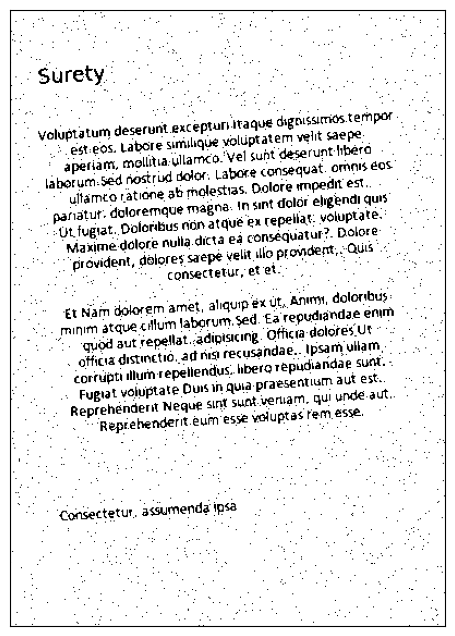

In [128]:
# generates random id and get it's image path and label path
id, sample_image_path, sample_label_path = get_random_img()

# displays image
display_image(path=sample_image_path)

# writes id and angle of sample in output
with open(sample_label_path) as f:
    angle = f.read()
print('ID of document is :', id)
print('Rotation angle is :', angle)

In [129]:
def display_image_grid(images, n=10, angles=None):
    fig = plt.figure(figsize=(20, 20))
    grid = ImageGrid(fig, 111,
                     nrows_ncols=(n, n),
                     axes_pad=0.25,
                     )

    i = 0
    for ax, im in zip(grid, images):
        ax.imshow(im, cmap='gray');
        ax.set_xticks([])
        ax.set_yticks([])
        if angles is not None:
            angle = angles[i] - 5
            ax.set_title(label=str(angle))
        i += 1

    plt.show()

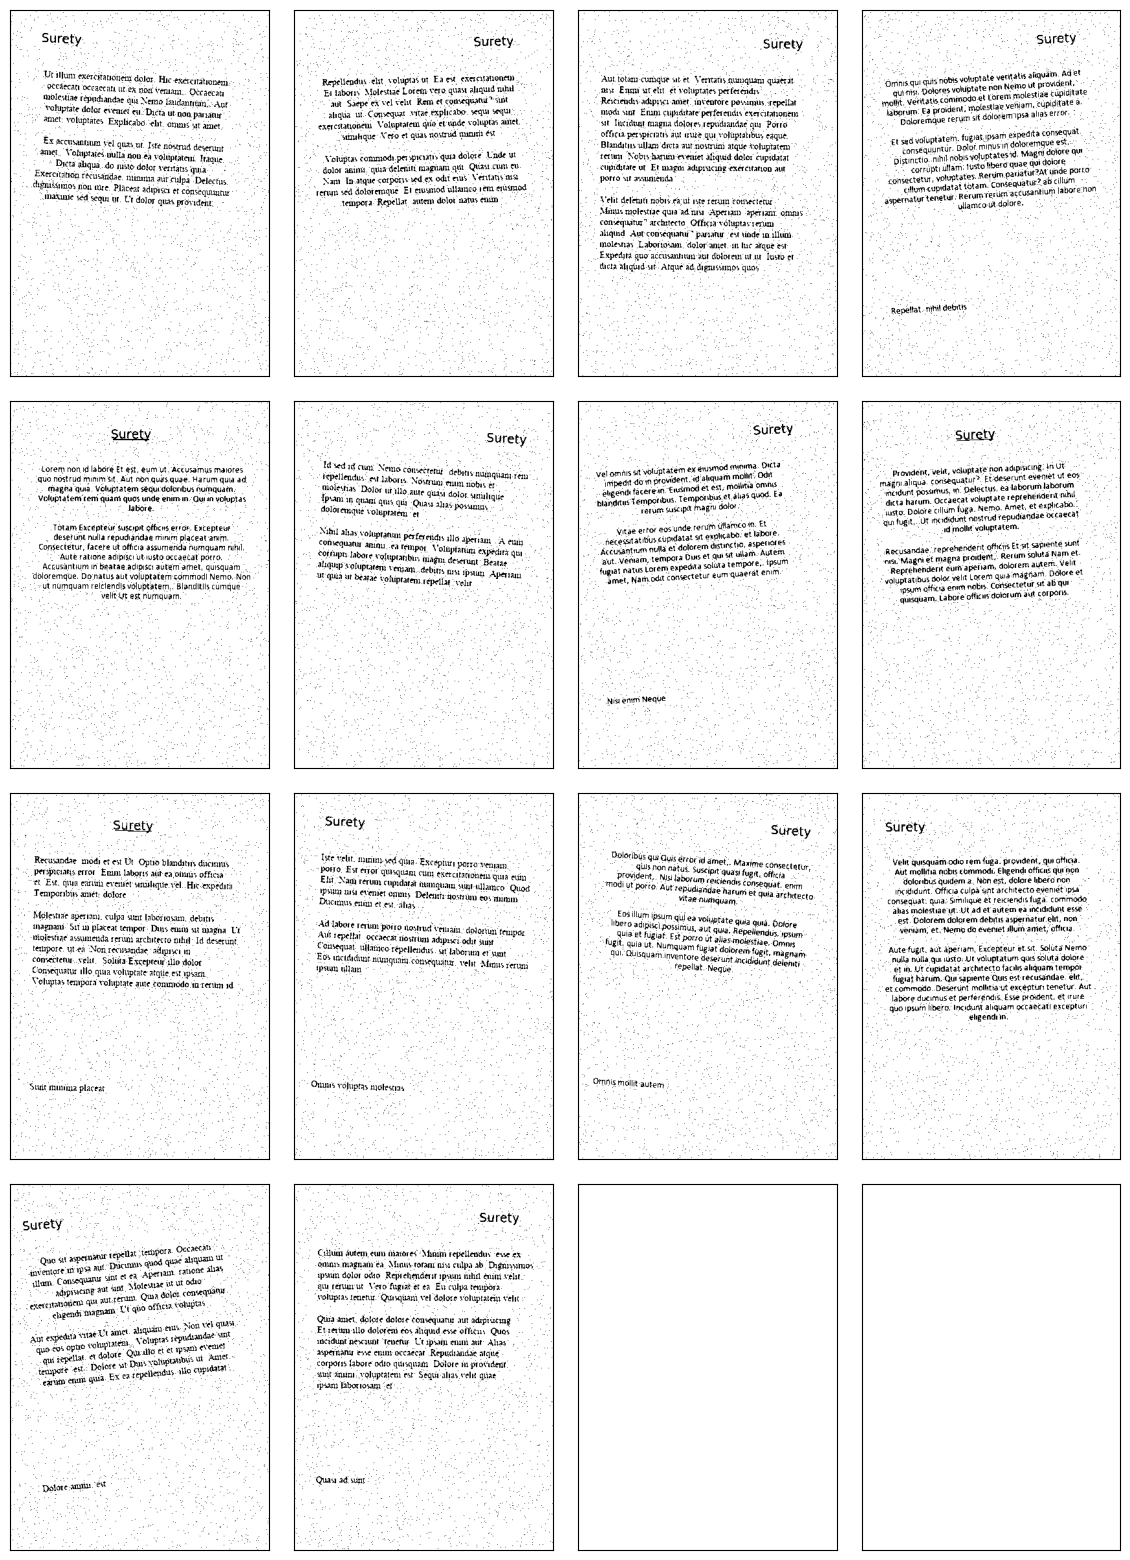

In [130]:
sampled_images = []
sampled_ids = []

for i in range(16):
    id, sample_image_path, sample_label_path = get_random_img()
    if id not in sampled_ids:
        img = Image.open(sample_image_path)
        sampled_ids.append(id)
        sampled_images.append(img)

display_image_grid(sampled_images, 4)

In [133]:
def denoise(img, to_PIL=True):
    img = denoise_tv_chambolle(img, weight=0.5)
    if to_PIL:
        Image.fromarray(img)
    return img

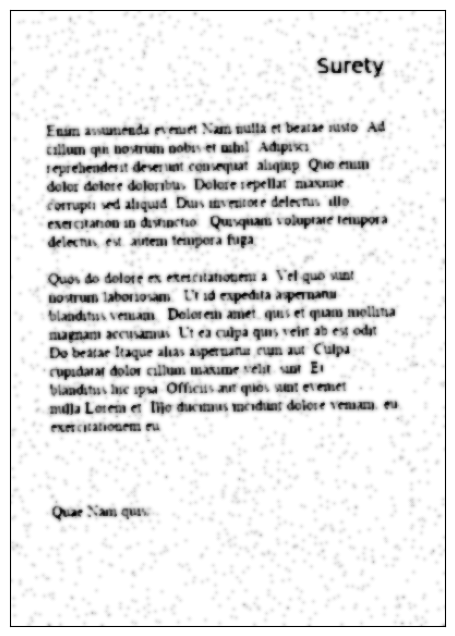

In [134]:
id, sample_image_path, sample_label_path = get_random_img()
img = Image.open(sample_image_path)
img = np.array(img)

img = denoise(img)
display_image(img=img)

In [ ]:
def fft(img, to_PIL=True):
    f = cv2.dft(np.float32(img))    # Discrete Fourier transform
    fshift = np.fft.fftshift(f)     # Shift the zero-frequency component to the center of the spectrum
    f_abs = np.abs(fshift) + 1.0    # shift to ensure no zeroes are present in image array
    f_img = 20 * np.log(f_abs)      # final result
    if to_PIL:
        return Image.fromarray(f_img)
    return f_img

## Функции потерь

#### Классификация

In [ ]:
def categorical_cross_entropy(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15) 
    loss = -np.sum(y_true * np.log(y_pred)) / len(y_true)
    return loss

#### Супер условный пример

In [ ]:
y_true = np.array([[1, 0, 0],
                   [0, 1, 0],
                   [0, 0, 1]])


y_pred = np.array([[0.7, 0.2, 0.1],
                   [0.1, 0.8, 0.1], 
                   [0.05, 0.15, 0.8]])

loss = categorical_cross_entropy(y_true, y_pred)
print(f"Потери: {loss}")

#### Регрессия

In [ ]:
def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

In [ ]:
def huber_loss(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    small_error = np.abs(error) <= delta
    large_error = np.abs(error) > delta

    loss = np.zeros_like(error)
    loss[small_error] = 0.5 * error[small_error] ** 2
    loss[large_error] = delta * np.abs(error[large_error]) - 0.5 * delta ** 2

    return np.mean(loss)

#### Супер условный пример

In [ ]:
y_true = np.array([3, -0.5, 2, 7])
y_pred = np.array([2.5, 0.0, 2, 8])

mae = mean_absolute_error(y_true, y_pred)
print(f"MAE: {mae}")

huber = huber_loss(y_true, y_pred, delta=1.0)
print(f"Huber Loss: {huber}")